In [6]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
from shapely import *
import random

import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'


In [24]:
sqrt3=np.sqrt(3)

In [42]:
#return a pandas.DataFrame of the cell positions.
#check for the reasonable side lengths
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

def cell_positions(layer, poly,
                   R_readout=0.4, sidelength=1.889, debug=False, wall_thickness=0.08, minCellAreaFraction=1/3,
                  augment_cells=False, wall_scint_gap=0.01, stagger="H3"):
    if wall_thickness!=0:
        poly=poly.buffer(-wall_thickness/2)
    
    y0=sidelength/2+min(poly.exterior.xy[1])
    
    nrows = int((max(poly.exterior.xy[1])-min(poly.exterior.xy[1]))/(sidelength*np.sqrt(3)/2)+3)
    
    y0=(max(poly.exterior.xy[1])+min(poly.exterior.xy[1]))/2-sidelength*np.sqrt(3)/2*((nrows-1)//2)
    
    
    ncol= int((max(poly.exterior.xy[0])-min(poly.exterior.xy[0]))/(sidelength*3/2))+4
    x0=min(poly.exterior.xy[0])
    
    
    
    # x,y are the position of the SiPM and dimple center
    # xh and yh are the position of the center of the hexagon.  
    # These are the same for a regular hexagon or any cropped hexagon that doesn't have a shifted dimple
    d={a:[] for a in "x y xh yh row col boundsx boundsy area dimpleshift cropped augmented scint_boundsx scint_boundsy scint_area deadzone".split()}
    
    if stagger=="H3":
        shiftX=[-sidelength, 0, sidelength][layer%3]
        shiftY=[0, 0, 0][layer%3]
    elif stagger=="H4":
        shiftX=[-sidelength, sidelength/2, -sidelength/4, -sidelength/4][layer%4]
        shiftY=[0, 0, sidelength*sqrt3/4, -sidelength*sqrt3/4][layer%4]
    else :
        shiftX=0
        shiftY=0
    phi=np.linspace(-2*np.pi/3, np.pi, 6)
    for i in range(-1,nrows):
        for j in range(-1, ncol):
            if (i +j) %2!=0:
                continue
            x=x0+j*sidelength*3/2+shiftX
            y=y0+sidelength*np.sqrt(3)/2*i+shiftY
            
            xh=x
            yh=x
            
            xc=x
            yc=y
            
            cellTooSmall=False
            point=Point(x,y)
            #check if the dimple fits inside the boundaries.
            if not point.buffer(R_readout).within(poly):
                hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
                overlap=poly.intersection(hexagon)
                if overlap.area==0:
                    continue
                
                # now see if shifting the dimple to the centroid will allow the dimple to fit
                # otherwise merge with neighbors
                centroid=overlap.centroid
                if not centroid.buffer(R_readout).within(poly):
                    cellTooSmall=True
                    
                # now see if the cell's area is more than a specified fraction of a 
                # standard hexagon's area.  otherwise merge with neighbors
                if overlap.area/hexagon.area <  minCellAreaFraction:
                    cellTooSmall=True
                    
                # if the cell fragment fails these criteria,
                # either merge it with one of its neighbors,
                # or flag the fragment as a deadzone
                if cellTooSmall and augment_cells:
                    continue
                elif cellTooSmall:
                    d['deadzone'].append(1)
                else:
                    d['deadzone'].append(0)
                xc,yc = centroid.xy[0],centroid.xy[1]
                
                if type(xc) != float:
                    xc=float(xc[0])
                if type(yc) != float:
                    yc=float(yc[0])
                
                d['dimpleshift'].append(1)
            else :
                d['dimpleshift'].append(0)
                d['deadzone'].append(0)
            #print(type(xc))
            d['x'].append(xc)
            d['y'].append(yc)
            
            d['xh'].append(x)
            d['yh'].append(y)
            
            d['row'].append(i)
            d['col'].append(j)
            
            
            hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
            if poly.contains(hexagon):
                cropped = 0
                d['boundsx'].append(hexagon.exterior.xy[0])
                d['boundsy'].append(hexagon.exterior.xy[1])
                d['area'].append(hexagon.area)
                #smaller hexagon for the scintillator cell.
                scint_sidelength=sidelength-(wall_thickness/2+wall_scint_gap)/(np.sqrt(3)/2)
                hexagon2=Polygon(zip(x+scint_sidelength*np.cos(phi),y+scint_sidelength*np.sin(phi)))
                d['scint_boundsx'].append(hexagon2.exterior.xy[0])
                d['scint_boundsy'].append(hexagon2.exterior.xy[1])
                d['scint_area'].append(hexagon2.area)
            elif not cellTooSmall :
                cropped = 1
                newpoly=poly.intersection(hexagon)
                #print(newpoly.exterior)
                d['boundsx'].append(newpoly.exterior.xy[0])
                d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                d['scint_boundsx'].append(scint.exterior.xy[0])
                d['scint_boundsy'].append(scint.exterior.xy[1])
                d['scint_area'].append(scint.area)
            
            else: # for entries where a cell is not placed
                cropped=1
                newpoly=poly.intersection(hexagon)
                if not isinstance(newpoly, Polygon): 
                    #only happens if cropping the cell splits it into multiple parts
                    #very rare, but don't want this to crash
                    d['boundsx'].append(newpoly.geoms[0].exterior.xy[0])
                    d['boundsy'].append(newpoly.geoms[0].exterior.xy[1])
                else :
                    d['boundsx'].append(newpoly.exterior.xy[0])
                    d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
                d['scint_boundsx'].append([])
                d['scint_boundsy'].append([])
                d['scint_area'].append(0)
                
                
            d['cropped'].append(cropped)
            d['augmented'].append(0) # no augmenting at this stage yet.  
    df=pd.DataFrame(d)
    
    
    # the cell augmentation feature merges small fragments of cells on the edge of the 
    # detector with their whole neighbors.  If we choose not to use this feature, then we can 
    if not augment_cells:
        if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={poly.area}, ratio= {sum(df.area)/poly.area}")
        return df
    
    
            

In [47]:

def draw_layer(layer, R_readout=0.4, sidelength=3.13, fillDimple=True, color=None, shade_deadzone=True,
              height=60, width=60, stagger="H3", minCellAreaFraction=1/3):
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    if color == None:
        color='krbg'[layer%(3 if stagger=="H3" else 4)] 
    
    for side in "LR":
        boundaries=Polygon(zip([-width/2,-width/2, width/2,width/2,-width/2], [-height/2, height/2,height/2,-height/2, -height/2]))
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color=color)
        df = cell_positions(layer,boundaries, R_readout, sidelength, stagger=stagger,minCellAreaFraction=minCellAreaFraction)
        for i in range(len(df)):
            plt.plot(df.boundsx[i], df.boundsy[i], color=color)
            if not df.deadzone[i]:
                plt.gca().add_patch(mpl.patches.Circle((df.x[i], df.y[i]), R_readout, color=color,
                                                          linestyle='' if fillDimple else '-',
                                                        fill=fillDimple))
            elif shade_deadzone:
                plt.gca().add_patch(mpl.patches.Polygon(list(zip(df.boundsx[i], df.boundsy[i])), color=color,
                                                       alpha=0.3))

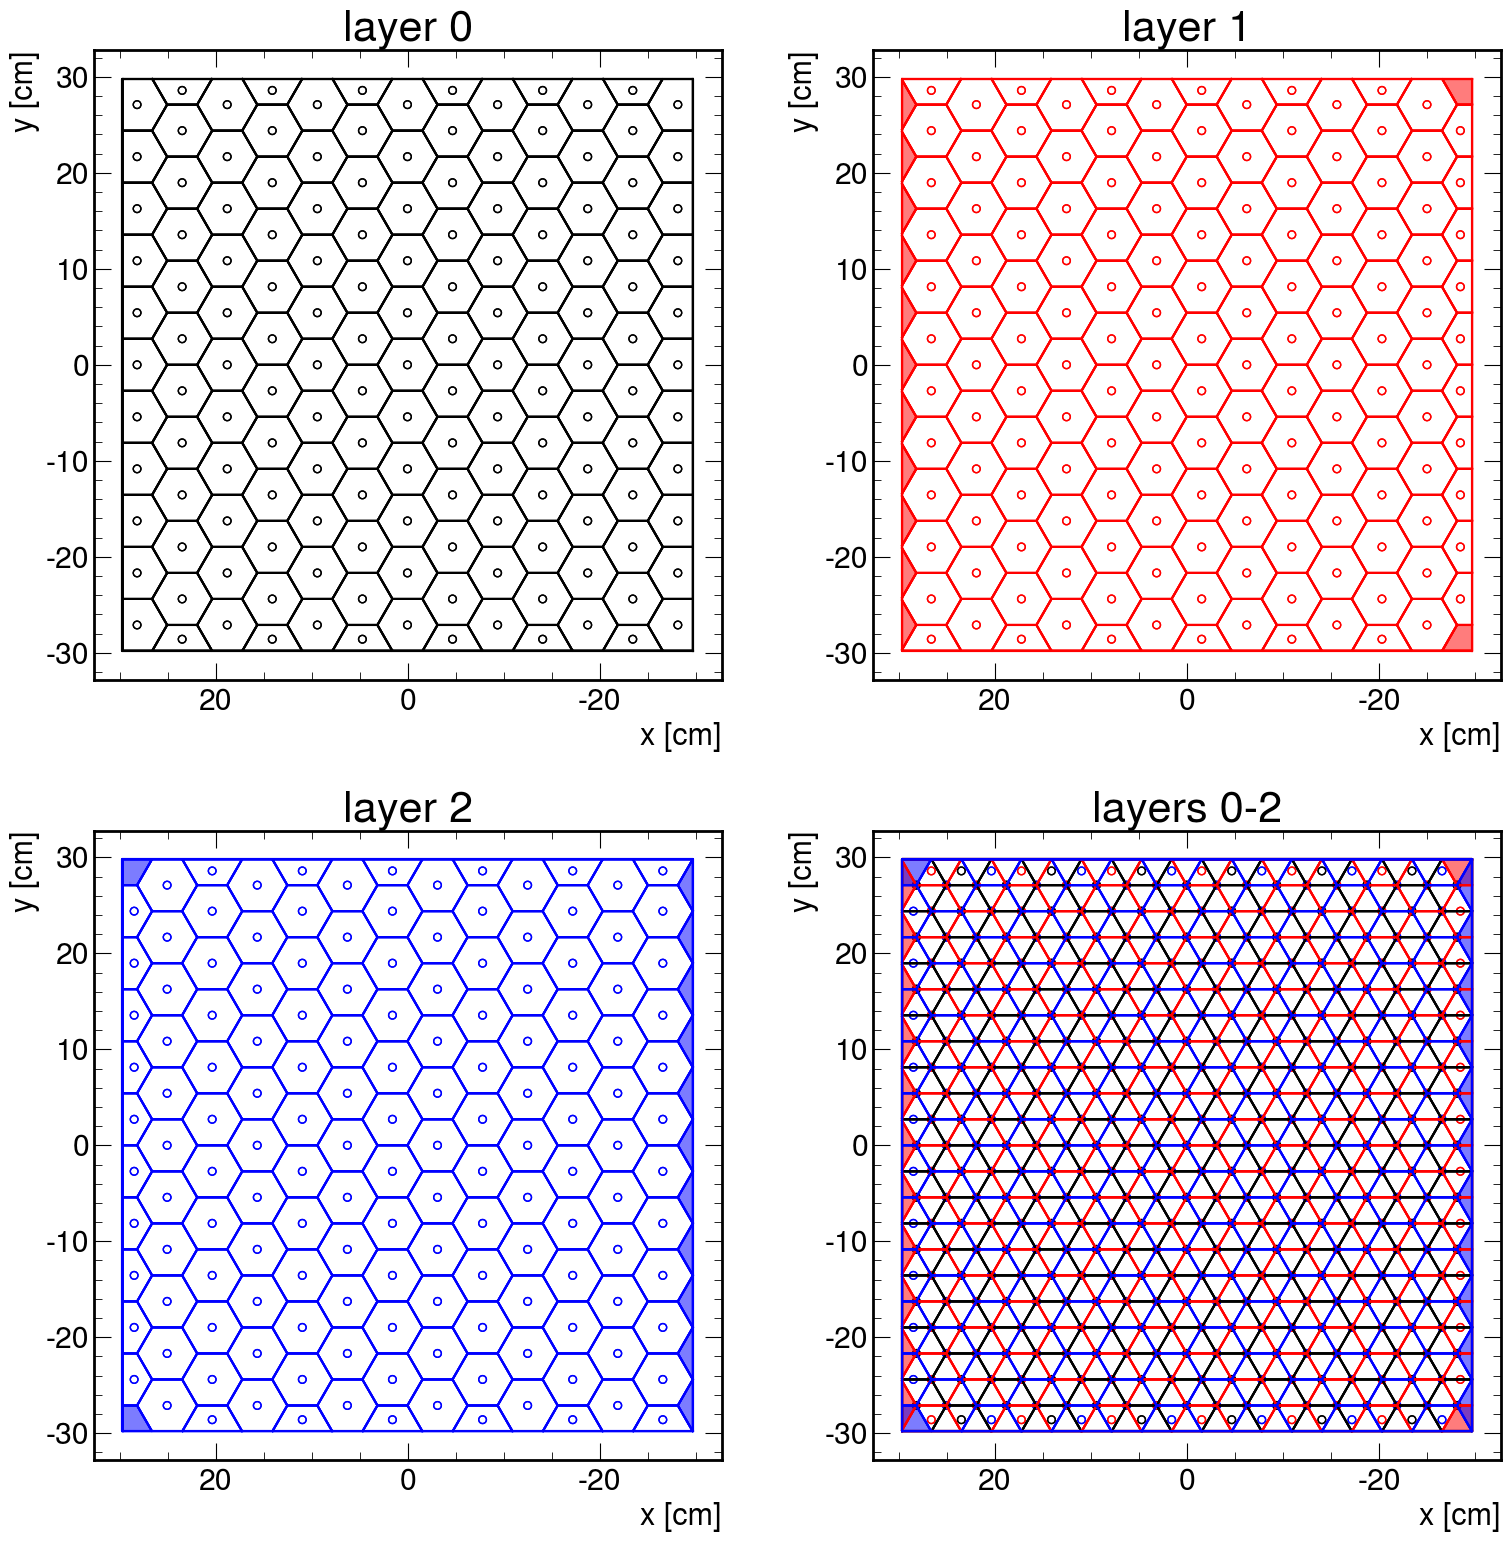

In [48]:

sidelength=3.13


arg=dict(fillDimple=False, sidelength=sidelength, width=sidelength*19, height=sidelength*11*np.sqrt(3))
fig,axs=plt.subplots(2,2, figsize=(16,16))
for i in range(3):

    plt.sca(axs[i//2][i%2])
    plt.title(f"layer {i}")
    draw_layer(i, **arg)
    plt.gca().set_aspect(1)
    plt.gca().invert_xaxis()
    plt.sca(axs[1][1])
    plt.title(f"layers 0-2")
    draw_layer(i, **arg)
    plt.gca().set_aspect(1)
axs[1][1].invert_xaxis()
for row in axs:
    for ax in row:
        ax.set_xlabel("x [cm]", fontsize=22)
        ax.set_ylabel("y [cm]", fontsize=22)
        
        
plt.tight_layout()
plt.savefig(f"Layers_0-2_zdc_h3.pdf")
plt.show()

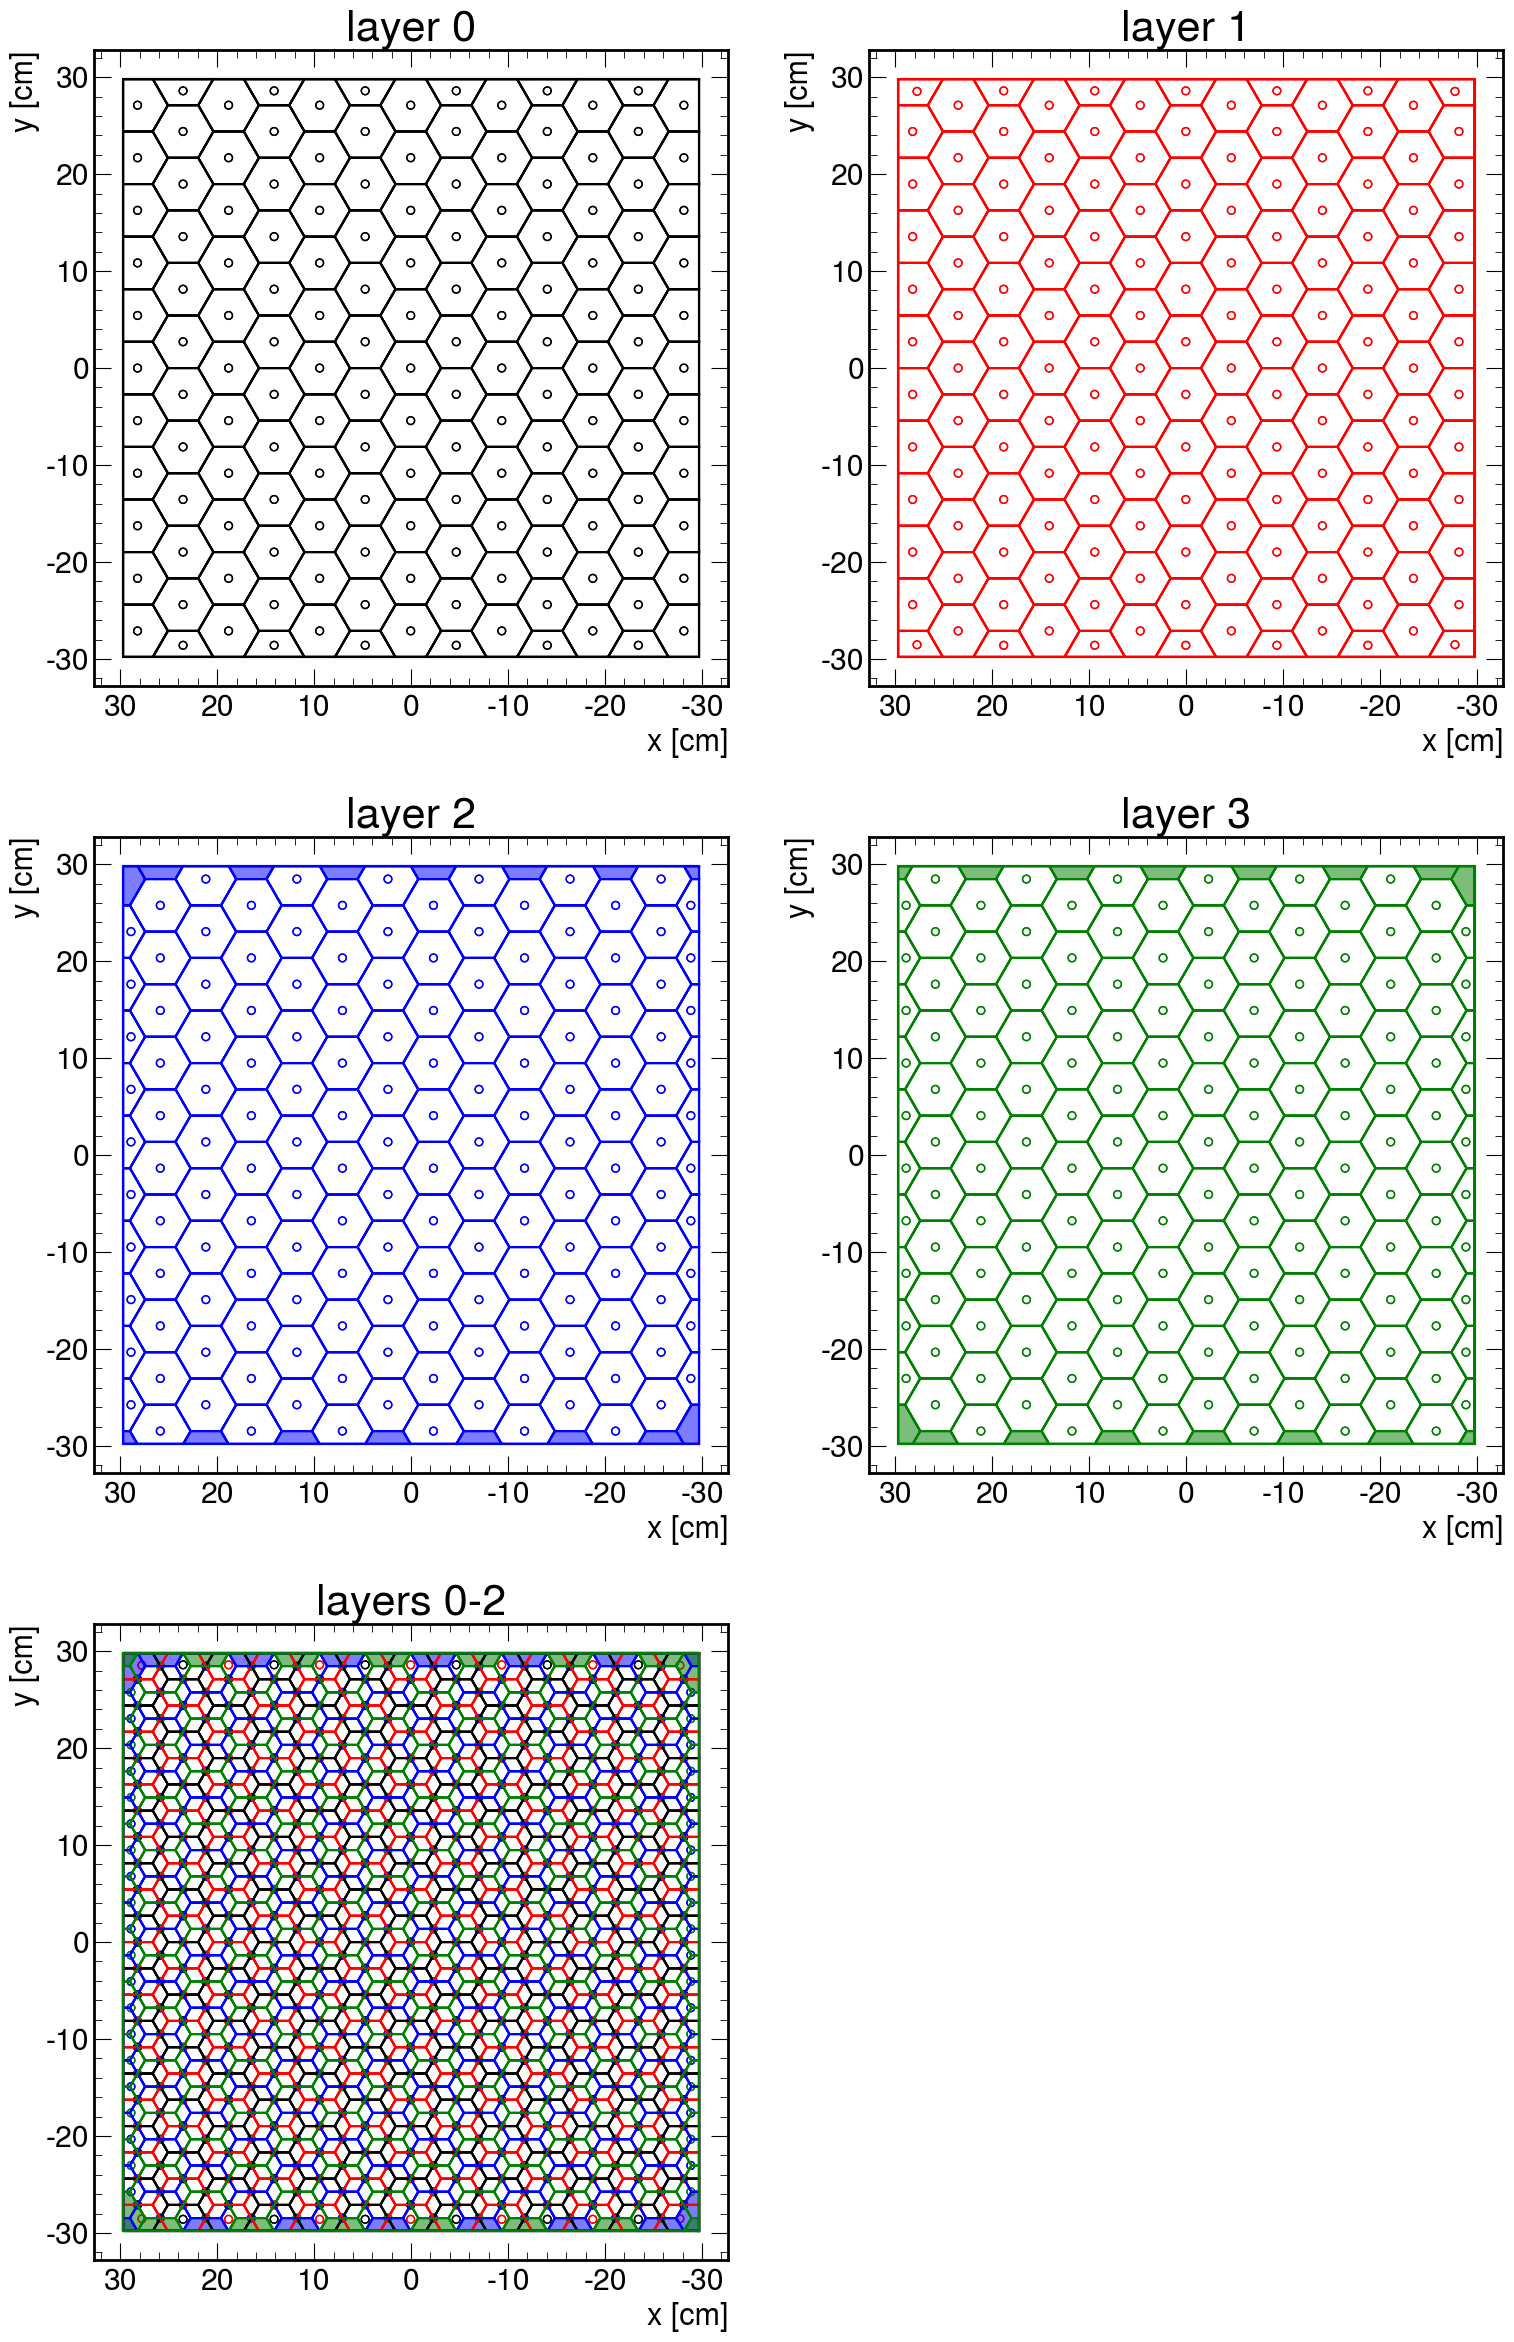

In [49]:
sidelength=3.13


arg=dict(fillDimple=False, sidelength=sidelength, width=sidelength*19, 
         height=sidelength*11*np.sqrt(3), stagger='H4',minCellAreaFraction=.3)
fig,axs=plt.subplots(3,2, figsize=(16,24))
for i in range(4):

    plt.sca(axs[i//2][i%2])
    plt.title(f"layer {i}")
    draw_layer(i, **arg)
    plt.gca().set_aspect(1)
    plt.gca().invert_xaxis()
    plt.sca(axs[2][0])
    plt.title(f"layers 0-2")
    draw_layer(i, **arg)
    plt.gca().set_aspect(1)
axs[2][0].invert_xaxis()

axs[2][0].set_aspect(1)
axs[2][1].set_aspect(1)

axs[2][1].axis('off')
for row in axs:
    for ax in row:
        ax.set_xlabel("x [cm]", fontsize=22)
        ax.set_ylabel("y [cm]", fontsize=22)
        
        
plt.tight_layout()
plt.savefig(f"Layers_0-2_zdc_h3.pdf")
plt.show()